In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline

### Settings

In [2]:
# Path settings
base_path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/"

# Settings for epoch selection method
which_mode = "best_onemetric"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "accuracy"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"

### Select classifier results

In [3]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025"]
for r, run in enumerate(list_runs):  # for each set of classifier runs
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns = ["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [4]:
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.757492,0.7575,0.649082,0.7575,0.913899,0.871367,0.799759,0.694427,0.570895
1,2,test,0.800993,0.8030,0.707730,0.8030,0.940217,0.906573,0.857208,0.766902,0.647103
2,3,test,0.822370,0.8225,0.742894,0.8225,0.947818,0.920114,0.874460,0.796260,0.685433
3,4,test,0.830732,0.8320,0.752837,0.8320,0.951595,0.925397,0.884033,0.812147,0.700000
4,5,test,0.835663,0.8365,0.759774,0.8365,0.953646,0.927685,0.888752,0.818952,0.708742


In [5]:
df_sel.head(5)

,accuracy,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.89884,test,30,0.802813,0.89884,0.897838,NaN,0.855978,0.947102,0.931167,0.969566,without_cloudy,train_A_over
1,0.938538,test_daytime,30,0.909884,0.938538,0.939112,NaN,0.956221,0.978783,0.986369,0.988324,without_cloudy,train_A_over
2,0.873684,test_night,30,0.669793,0.873684,0.869123,NaN,0.703408,0.918439,0.849512,0.953797,without_cloudy,train_A_over
3,0.923899,train_dev_A_over,12,0.923793,0.923899,0.923793,NaN,0.972457,0.973417,0.98534,0.984951,without_cloudy,train_A_over
4,0.893041,valid,30,0.789244,0.893041,0.893142,NaN,0.858185,0.952391,0.939838,0.972414,without_cloudy,train_A_over


In [6]:
# print best epochs for each metric, if available
if which_mode == "best_eachmetric":
    print(df_sel_epochs.head(12))

### Print results for best epochs gouped by split

In [7]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy','f1_score_macro', 'f1_score_micro', 'f1_score_weighted', 'pr_macro', 'pr_micro', 'roc_auc_macro', 'roc_auc_micro']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

#### Valid-All

In [8]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(12)


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,30,train_A_over,without_cloudy,0.893041,0.789244,0.893041,0.893142,0.858185,0.952391,0.939838,0.972414
1,39,train_B_over,without_cloudy,0.897552,0.80638,0.897552,0.898291,0.880939,0.958424,0.954027,0.97604
2,32,train_C_over,without_cloudy,0.88982,0.795119,0.88982,0.8931,0.873646,0.950857,0.954703,0.972545
3,27,train_A_over_ganaug_025,without_cloudy,0.88982,0.78597,0.88982,0.890425,0.861707,0.950622,0.944337,0.971908
4,27,train_A_over_ganaug_050,without_cloudy,0.884021,0.786242,0.884021,0.886765,0.856481,0.944032,0.942439,0.967604
5,23,train_B_over_ganaug_025,without_cloudy,0.91366,0.831803,0.91366,0.913302,0.882669,0.960559,0.953268,0.977541
6,36,train_A_over,with_cloudy,0.832,0.751538,0.832,0.830636,0.805484,0.886898,0.927669,0.953876
7,35,train_B_over,with_cloudy,0.8395,0.775809,0.8395,0.839658,0.840947,0.900689,0.940013,0.959489
8,35,train_C_over,with_cloudy,0.8285,0.76104,0.8285,0.829755,0.834233,0.894224,0.939627,0.956511
9,34,train_A_over_ganaug_025,with_cloudy,0.816,0.7366,0.816,0.817824,0.803605,0.862682,0.921356,0.945418


#### Valid-Night

In [9]:
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(12)


=== valid_night ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,30,train_A_over,without_cloudy,0.875789,0.681851,0.875789,0.874425,0.72011,0.928701,0.873064,0.95854
1,39,train_B_over,without_cloudy,0.887368,0.735891,0.887368,0.888559,0.79225,0.942573,0.911709,0.966657
2,35,train_C_over,without_cloudy,0.876842,0.731714,0.876842,0.883492,0.80382,0.930945,0.919449,0.96158
3,27,train_A_over_ganaug_025,without_cloudy,0.874737,0.684035,0.874737,0.873889,0.736821,0.928244,0.887934,0.959963
4,27,train_A_over_ganaug_050,without_cloudy,0.865263,0.696564,0.865263,0.870254,0.743495,0.919382,0.887129,0.953647
5,16,train_B_over_ganaug_025,without_cloudy,0.909474,0.764906,0.909474,0.905769,0.808342,0.951131,0.913236,0.97212
6,26,train_A_over,with_cloudy,0.842,0.625347,0.842,0.83676,0.641828,0.872777,0.844902,0.946179
7,34,train_B_over,with_cloudy,0.866,0.69818,0.866,0.863483,0.73939,0.909754,0.889369,0.960607
8,39,train_C_over,with_cloudy,0.849,0.687554,0.849,0.851635,0.737191,0.899728,0.89354,0.957516
9,34,train_A_over_ganaug_025,with_cloudy,0.811,0.595619,0.811,0.815981,0.655395,0.835906,0.84289,0.934741


In [10]:
print("\n===", split, "Difference to A ===")
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:5,col] = df_cursplit_diff.loc[0:5,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[6:11,col] = df_cursplit_diff.loc[6:11,col] - df_cursplit.loc[6,col]
df_cursplit_diff.loc[:,cols2print].head(12)


=== valid_night Difference to A ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0
1,9,train_B_over,without_cloudy,0.0115789,0.0540394,0.0115789,0.0141344,0.0721398,0.0138724,0.0386451,0.00811662
2,5,train_C_over,without_cloudy,0.00105263,0.0498624,0.00105263,0.0090672,0.0837098,0.0022448,0.0463849,0.00303961
3,-3,train_A_over_ganaug_025,without_cloudy,-0.00105263,0.00218416,-0.00105263,-0.000535999,0.0167114,-0.000456094,0.01487,0.00142216
4,-3,train_A_over_ganaug_050,without_cloudy,-0.0105263,0.0147132,-0.0105263,-0.00417089,0.0233854,-0.00931874,0.0140648,-0.00489391
5,-14,train_B_over_ganaug_025,without_cloudy,0.0336842,0.0830551,0.0336842,0.0313441,0.0882324,0.0224303,0.0401722,0.0135792
6,0,train_A_over,with_cloudy,0,0,0,0,0,0,0,0
7,8,train_B_over,with_cloudy,0.024,0.0728331,0.024,0.0267229,0.0975623,0.0369777,0.044467,0.014428
8,13,train_C_over,with_cloudy,0.007,0.0622066,0.007,0.0148746,0.0953633,0.0269516,0.0486378,0.0113373
9,8,train_A_over_ganaug_025,with_cloudy,-0.031,-0.0297282,-0.031,-0.0207793,0.0135674,-0.0368701,-0.00201264,-0.011438


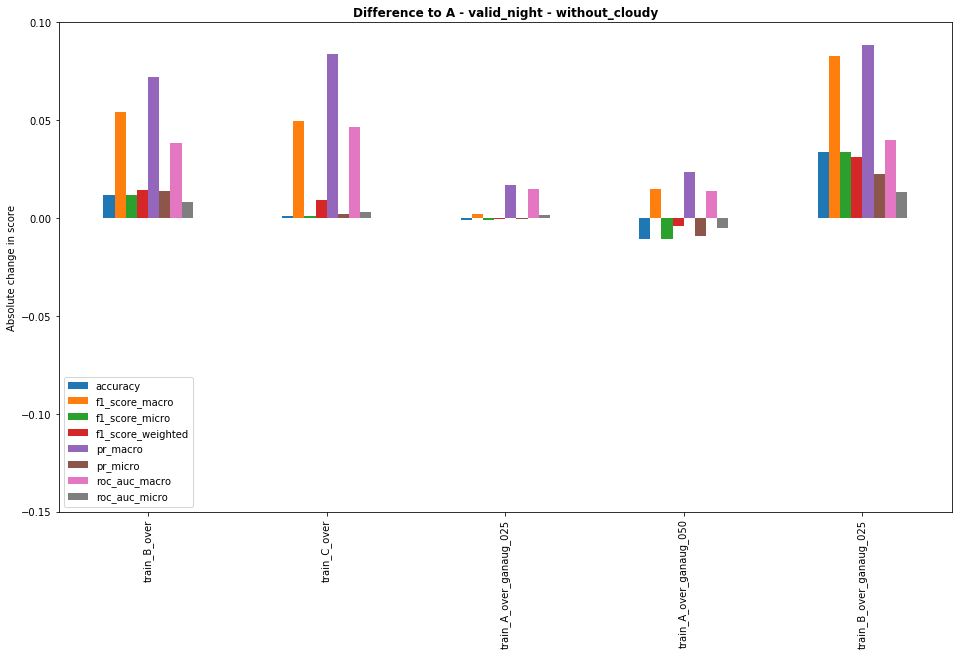

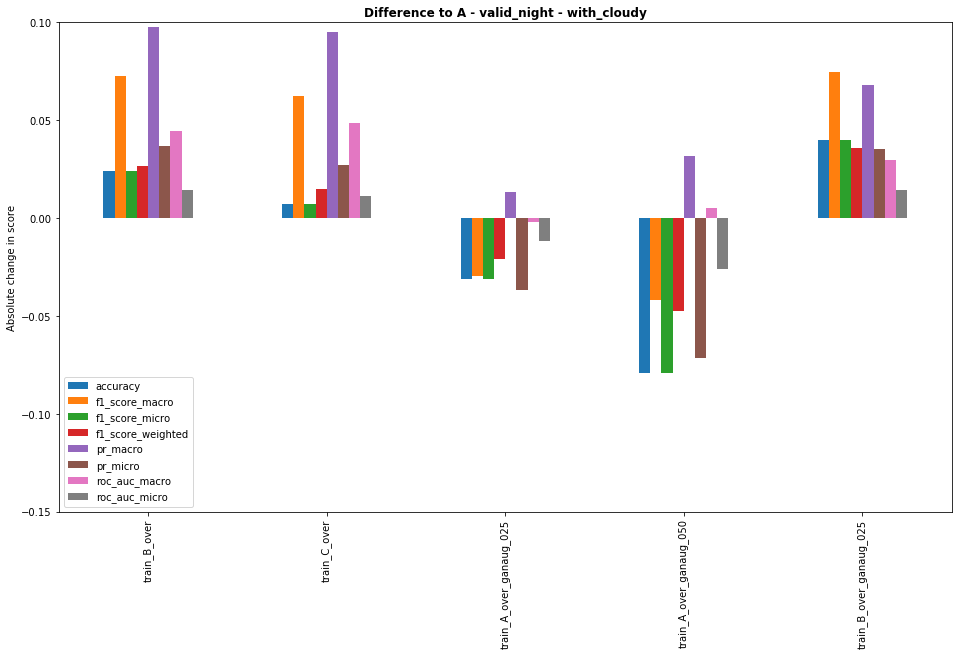

In [11]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:5, :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")

#### Test-All

In [12]:
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:,cols2print].head(12)


=== test ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,30,train_A_over,without_cloudy,0.89884,0.802813,0.89884,0.897838,0.855978,0.947102,0.931167,0.969566
1,33,train_B_over,without_cloudy,0.902706,0.821133,0.902706,0.903748,0.882451,0.952568,0.944287,0.973552
2,34,train_C_over,without_cloudy,0.896263,0.808772,0.896263,0.898562,0.876829,0.945845,0.946071,0.970276
3,27,train_A_over_ganaug_025,without_cloudy,0.885309,0.779517,0.885309,0.88575,0.850393,0.945518,0.934657,0.968476
4,39,train_A_over_ganaug_050,without_cloudy,0.87951,0.772439,0.87951,0.882423,0.845764,0.938916,0.931157,0.965058
5,19,train_B_over_ganaug_025,without_cloudy,0.913015,0.82681,0.913015,0.912103,0.874226,0.954303,0.943301,0.973599
6,35,train_A_over,with_cloudy,0.8485,0.776043,0.8485,0.848104,0.831869,0.898752,0.930479,0.958287
7,35,train_B_over,with_cloudy,0.8555,0.793282,0.8555,0.855876,0.847821,0.902924,0.94287,0.962279
8,35,train_C_over,with_cloudy,0.85,0.782636,0.85,0.850954,0.850694,0.90301,0.944,0.961269
9,34,train_A_over_ganaug_025,with_cloudy,0.8165,0.742473,0.8165,0.819679,0.816091,0.872853,0.92712,0.948138


#### Test-Night

In [13]:
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:,cols2print].head(12)


=== test_night ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,30,train_A_over,without_cloudy,0.873684,0.669793,0.873684,0.869123,0.703408,0.918439,0.849512,0.953797
1,33,train_B_over,without_cloudy,0.888421,0.740417,0.888421,0.889937,0.789365,0.926588,0.889993,0.961358
2,34,train_C_over,without_cloudy,0.877895,0.71954,0.877895,0.882013,0.782574,0.916254,0.891805,0.956025
3,27,train_A_over_ganaug_025,without_cloudy,0.858947,0.650057,0.858947,0.859315,0.70578,0.917585,0.865235,0.953377
4,39,train_A_over_ganaug_050,without_cloudy,0.853684,0.658343,0.853684,0.859001,0.711012,0.90589,0.86347,0.947935
5,37,train_B_over_ganaug_025,without_cloudy,0.906316,0.74468,0.906316,0.901057,0.777185,0.937169,0.886844,0.965219
6,35,train_A_over,with_cloudy,0.859,0.657703,0.859,0.852067,0.682197,0.885453,0.846709,0.950415
7,16,train_B_over,with_cloudy,0.867,0.701427,0.867,0.866862,0.742923,0.892606,0.890373,0.957618
8,40,train_C_over,with_cloudy,0.858,0.659759,0.858,0.853619,0.743259,0.894478,0.886673,0.957056
9,34,train_A_over_ganaug_025,with_cloudy,0.799,0.595094,0.799,0.809468,0.654556,0.832994,0.842911,0.93091


In [14]:
print("\n===", split, "Difference to A ===")
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:5,col] = df_cursplit_diff.loc[0:5,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[6:11,col] = df_cursplit_diff.loc[6:11,col] - df_cursplit.loc[6,col]
df_cursplit_diff.loc[:,cols2print].head(12)


=== test_night Difference to A ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0
1,3,train_B_over,without_cloudy,0.0147368,0.0706247,0.0147368,0.0208137,0.0859569,0.00814907,0.0404812,0.0075615
2,4,train_C_over,without_cloudy,0.00421053,0.0497474,0.00421053,0.0128893,0.0791657,-0.00218496,0.0422925,0.00222853
3,-3,train_A_over_ganaug_025,without_cloudy,-0.0147368,-0.0197356,-0.0147368,-0.00980871,0.00237148,-0.000853405,0.015723,-0.000419668
4,9,train_A_over_ganaug_050,without_cloudy,-0.02,-0.0114499,-0.02,-0.010122,0.00760398,-0.0125489,0.0139577,-0.00586233
5,7,train_B_over_ganaug_025,without_cloudy,0.0326316,0.0748873,0.0326316,0.0319336,0.0737767,0.0187296,0.0373317,0.0114219
6,0,train_A_over,with_cloudy,0,0,0,0,0,0,0,0
7,-19,train_B_over,with_cloudy,0.008,0.0437235,0.008,0.014795,0.0607258,0.00715261,0.0436637,0.00720333
8,5,train_C_over,with_cloudy,-0.001,0.0020559,-0.001,0.00155211,0.0610619,0.00902487,0.0399636,0.00664083
9,-1,train_A_over_ganaug_025,with_cloudy,-0.06,-0.062609,-0.06,-0.0425982,-0.0276417,-0.0524599,-0.00379807,-0.0195052


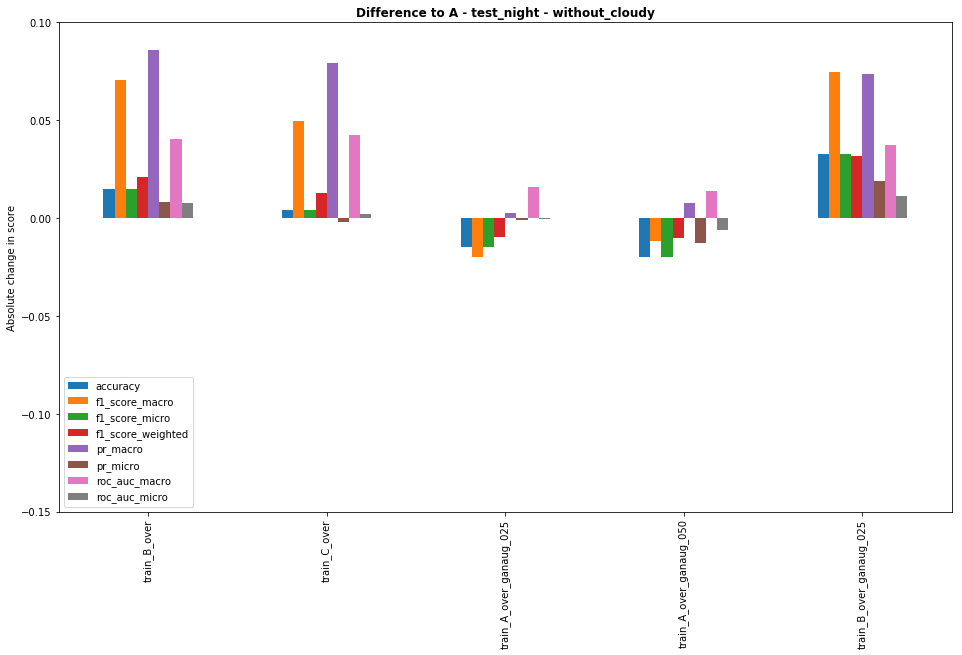

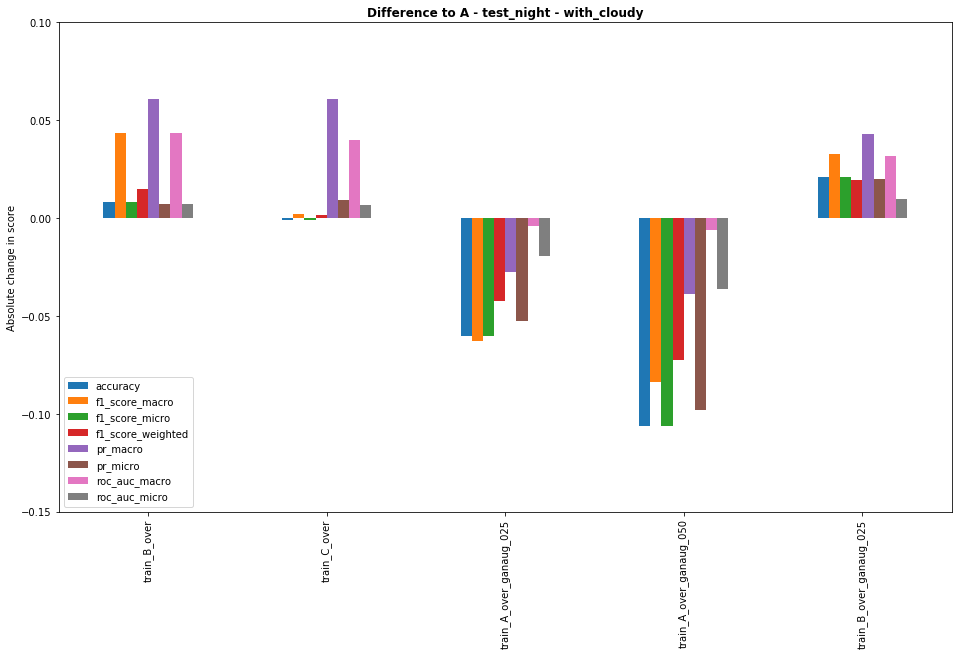

In [15]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:5, :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")